
Using panel file
data\processed\master_panel_phaseC_rebuild.csv


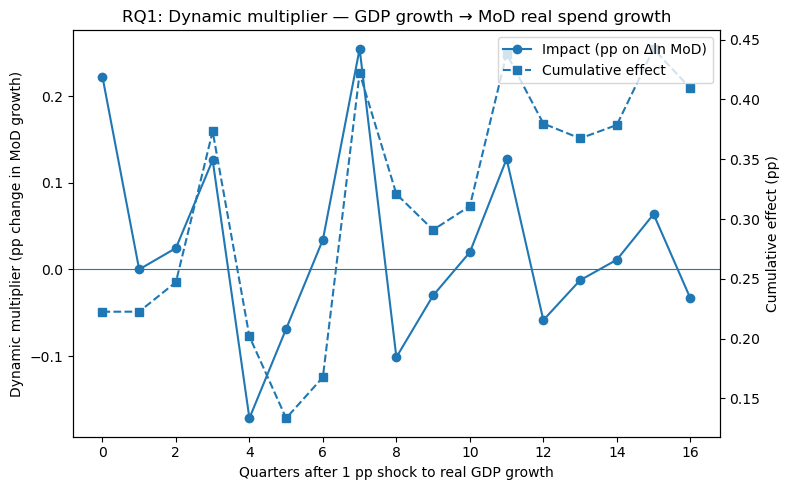


Bounds test skipped or failed gracefully; see figures\tables\phaseD\RQ1_bounds_summary.txt

RQ1 — Growth-ARDL results (OLS grid-selected)
                                 OLS Regression Results                                
Dep. Variable:         g_mod_total_pp   R-squared (uncentered):                   0.559
Model:                            OLS   Adj. R-squared (uncentered):              0.471
Method:                 Least Squares   F-statistic:                              6.335
Date:                Tue, 02 Sep 2025   Prob (F-statistic):                    4.38e-07
Time:                        01:41:36   Log-Likelihood:                         -139.90
No. Observations:                  72   AIC:                                      303.8
Df Residuals:                      60   BIC:                                      331.1
Df Model:                          12                                                  
Covariance Type:            nonrobust                                

In [1]:
# ============================================================
# Phase D — RQ1 (Total)
# Δln(MoD total) growth response (pp) to a 1 pp shock in Δln(real GDP)
#
# Robust to your layout:
#   - Prefers /data/processed/ardl_ready_panel.{parquet,csv}
#   - Falls back to /data/processed/master_panel_phaseC_rebuild.csv
#   - If real GDP missing, merges ABMI (real GDP index) from /data/interim
#
# Saves:
#   figures/phaseD/dynamic_multiplier_gdp_to_mod_total_RQ1.png
#   figures/tables/phaseD/RQ1_total_params.csv
#   figures/tables/phaseD/RQ1_total_impulse_summary.csv
#   figures/tables/phaseD/RQ1_bounds_summary.txt (if available)
#   figures/tables/phaseD/RQ1_run_metadata.json
#   And now: also DISPLAYS the figure inline under the cell
# ============================================================

import json, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display  # <-- added

warnings.filterwarnings("ignore")

# ---------------------- Paths ----------------------
FIG_DIR = Path("figures/phaseD"); FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR = Path("figures/tables/phaseD"); TAB_DIR.mkdir(parents=True, exist_ok=True)

CAND_PANEL = [
    Path("data/processed/ardl_ready_panel.parquet"),
    Path("data/processed/ardl_ready_panel.csv"),
    Path("/data/processed/ardl_ready_panel.parquet"),
    Path("/data/processed/ardl_ready_panel.csv"),
    Path("/mnt/data/ardl_ready_panel.parquet"),
    Path("/mnt/data/ardl_ready_panel.csv"),

    Path("data/processed/master_panel_phaseC_rebuild.csv"),
    Path("/data/processed/master_panel_phaseC_rebuild.csv"),
    Path("/mnt/data/master_panel_phaseC_rebuild.csv"),

    # Additional fallbacks (latest master_panel*)
    *sorted(Path("data/processed").glob("master_panel*.parquet")),
    *sorted(Path("data/processed").glob("master_panel*.csv")),
    *sorted(Path("/mnt/data").glob("master_panel*.parquet")),
    *sorted(Path("/mnt/data").glob("master_panel*.csv")),
]

CAND_ABMI = [
    Path("data/interim/abmi_q.csv"),
    Path("/data/interim/abmi_q.csv"),
    Path("/mnt/data/abmi_q.csv"),
    Path("data/interim/series-280625_tidy.csv"),
    Path("/data/interim/series-280625_tidy.csv"),
    Path("/mnt/data/series-280625_tidy.csv"),
    Path("data/raw/series-280625.csv"),
    Path("/data/raw/series-280625.csv"),
    Path("/mnt/data/series-280625.csv"),
]

# ------------------ Utilities ----------------------
def _latest_existing(paths):
    paths = [p for p in paths if p.exists()]
    return sorted(paths, key=lambda p: p.stat().st_mtime)[-1] if paths else None

def _coerce_to_quarter_index_from_series(s: pd.Series):
    ss = s.astype(str).str.strip()
    # Normalize "YYYY-Qn" / "YYYY Qn" / "Qn YYYY" -> "YYYYQn"
    ss1 = ss.str.replace(r"(?i)^\s*(\d{4})\s*[-/ ]?\s*Q([1-4])\s*$", r"\1Q\2", regex=True)
    ss1 = ss1.str.replace(r"(?i)^\s*Q([1-4])\s*[-/ ]?\s*(\d{4})\s*$", r"\2Q\1", regex=True)
    try:
        return pd.PeriodIndex(ss1, freq="Q")
    except Exception:
        pass
    dt = pd.to_datetime(s, errors="coerce")
    if not dt.isna().all():
        return dt.to_period("Q")
    return None

def _ensure_quarter_index(df: pd.DataFrame):
    if isinstance(df.index, pd.PeriodIndex):
        try:
            return df.copy().set_index(df.index.asfreq("Q"))
        except Exception:
            pass
    candidates = [c for c in df.columns if re.search(r"(quarter|qtr|period|date|time)", str(c), re.I)]
    if not candidates:
        raise ValueError("No quarter/date column found to build a quarterly index.")
    for cand in candidates:
        qidx = _coerce_to_quarter_index_from_series(df[cand])
        if qidx is not None and not qidx.isna().all():
            out = df.copy()
            out.index = qidx
            return out
    raise ValueError(f"None of the candidate columns {candidates} parsed to a quarterly PeriodIndex.")

def _pick_col(df, regex_list):
    for pat in regex_list:
        for c in df.columns:
            if re.search(pat, str(c), flags=re.I):
                return c
    return None

def _growth_pp(series):
    s = pd.to_numeric(series, errors="coerce")
    s = s.where(s > 0)
    return 100.0 * np.log(s).diff()

def _print_header(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

# ----------------- Load main panel -----------------
panel_path = _latest_existing(CAND_PANEL)
if panel_path is None:
    raise FileNotFoundError("No processed panel found. Expected ardl_ready_panel, master_panel_phaseC_rebuild, or master_panel*.")

_print_header("Using panel file")
print(panel_path)

if panel_path.suffix.lower() == ".parquet":
    df = pd.read_parquet(panel_path)
else:
    df = pd.read_csv(panel_path)

df = _ensure_quarter_index(df)
df = df.loc[(df.index >= pd.Period("2004Q1")) & (df.index <= pd.Period("2024Q4"))].copy()

# ----------------- Try direct growths -----------------
gdp_g_col = _pick_col(df, [r"\bg_gdp_pp\b", r"\bgdp_pp\b", r"\bgdp_growth_pp\b"])
mod_g_col = _pick_col(df, [r"\bg_mod_total_pp\b", r"\bmod_total_pp\b", r"\bmod_growth_pp\b"])
direct_growths_ok = gdp_g_col is not None and mod_g_col is not None

# ----------------- Otherwise derive from levels -----------------
gdp_real_col = _pick_col(df, [
    r"\bgdp[_\s-]*real(_mn)?\b",
    r"\babmi\b", r"\bgdp.*(chain|volume|cvm)\b",
    r"\breal[_\s-]*gdp\b"
])
mod_real_col = _pick_col(df, [
    r"\bmod[_\s-]*total[_\s-]*real\b",
    r"\bdefence.*total.*real\b",
    r"\bmod.*total.*(chain|volume|cvm|const|2015=100|2019=100)\b"
])

abmi_used = False
if (not direct_growths_ok) and (gdp_real_col is None):
    abmi_path = _latest_existing(CAND_ABMI)
    if abmi_path is not None:
        abmi = pd.read_csv(abmi_path)
        abmi = _ensure_quarter_index(abmi)
        abmi_val_col = _pick_col(abmi, [r"\bvalue\b", r"\babmi\b", r"\bgdp.*(index|cvm|volume)\b"])
        if abmi_val_col is None:
            num_cols = [c for c in abmi.columns if pd.api.types.is_numeric_dtype(abmi[c])]
            if num_cols: abmi_val_col = num_cols[0]
        if abmi_val_col is None:
            raise KeyError(f"ABMI file found at {abmi_path} but no numeric value column detected.")
        df = df.join(abmi[[abmi_val_col]].rename(columns={abmi_val_col: "abmi_index"}), how="left")
        gdp_real_col = "abmi_index"
        abmi_used = True

if not direct_growths_ok:
    if mod_real_col is None:
        raise KeyError("Missing real MoD total column (e.g., 'mod_total_real').")
    if gdp_real_col is None:
        raise KeyError("Missing real GDP (e.g., 'gdp_real_mn' or ABMI).")

# ----------------- Build working dataset -----------------
if direct_growths_ok:
    y = pd.to_numeric(df[mod_g_col], errors="coerce").rename("g_mod_total_pp")
    x = pd.to_numeric(df[gdp_g_col], errors="coerce").rename("g_gdp_pp")
else:
    y = _growth_pp(df[mod_real_col]).rename("g_mod_total_pp")
    x = _growth_pp(df[gdp_real_col]).rename("g_gdp_pp")

gx = pd.concat([y, x], axis=1).dropna()
if gx.empty:
    raise RuntimeError("After computing growths and aligning, no overlapping observations remain (2004–2024).")

# ----------------- ARDL(p,q) via AIC grid search (version-proof) ------------
import statsmodels.api as sm

def _build_ardl_design(y, x, p, q, include_const=False):
    """
    Build design for ARDL(p,q): y_t = c + sum_{i=1..p} a_i y_{t-i} + sum_{j=0..q} b_j x_{t-j} + u_t
    Returns (Y, X, colnames) aligned and NaNs dropped. Column names follow "Lk.var".
    """
    df0 = pd.concat([y, x], axis=1).copy()
    yname, xname = y.name, x.name
    for i in range(1, p+1):
        df0[f"L{i}.{yname}"] = df0[yname].shift(i)
    for j in range(0, q+1):
        df0[f"L{j}.{xname}"] = df0[xname].shift(j)
    df0 = df0.dropna()
    Y = df0[yname].astype(float)
    cols = [f"L{i}.{yname}" for i in range(1, p+1)] + [f"L{j}.{xname}" for j in range(0, q+1)]
    X = df0[cols].astype(float)
    if include_const:
        X = sm.add_constant(X, has_constant="add")
    return Y, X, cols

def _grid_aic(y, x, pmax=8, qmax=8, include_const=False, min_obs=40):
    best = None
    best_aic = np.inf
    for p in range(1, pmax+1):
        for q in range(0, qmax+1):
            try:
                Y, X, cols = _build_ardl_design(y, x, p, q, include_const=include_const)
                if len(Y) < min_obs:
                    continue
                res = sm.OLS(Y, X).fit()
                aic = res.aic
                if aic < best_aic:
                    best_aic = aic
                    best = (p, q, res, cols)
            except Exception:
                continue
    if best is None:
        # relax min_obs if too strict
        for p in range(1, pmax+1):
            for q in range(0, qmax+1):
                try:
                    Y, X, cols = _build_ardl_design(y, x, p, q, include_const=include_const)
                    res = sm.OLS(Y, X).fit()
                    aic = res.aic
                    if aic < best_aic:
                        best_aic = aic
                        best = (p, q, res, cols)
                except Exception:
                    continue
    if best is None:
        raise RuntimeError("Could not select ARDL orders — check sample size/NaNs.")
    return best  # (p, q, res, cols)

T = len(gx)
pmax = qmax = int(min(8, max(2, np.floor(T/10))))  # conservative heuristic
p_sel, q_sel, res, reg_cols = _grid_aic(gx["g_mod_total_pp"], gx["g_gdp_pp"], pmax=pmax, qmax=qmax, include_const=False, min_obs=30)

# ----------------- Dynamic multipliers (1 pp shock) -----------------
def _irf_from_ols(res, y_name, x_name, p, q, H=16):
    params = res.params
    a = [params.get(f"L{i}.{y_name}", 0.0) for i in range(1, p+1)]
    b = [params.get(f"L{j}.{x_name}", 0.0) for j in range(0, q+1)]
    psi = np.zeros(H+1)
    psi[0] = b[0] if b else 0.0
    for h in range(1, H+1):
        bh = b[h] if h < len(b) else 0.0
        psi[h] = bh + sum(a[i-1]*psi[h-i] for i in range(1, min(len(a), h)+1))
    return psi

H = 16
psi = _irf_from_ols(res, "g_mod_total_pp", "g_gdp_pp", p_sel, q_sel, H=H)
impulse_tbl = pd.DataFrame({"horizon_q": np.arange(H+1), "psi_pp": psi})
impulse_tbl["cum_pp"] = impulse_tbl["psi_pp"].cumsum()

# ----------------- Save params & impulse table -----------------
params_df = res.params.to_frame("coef")
params_df["std_err"] = res.bse
params_df["pvalue"] = res.pvalues
params_df.to_csv(TAB_DIR / "RQ1_total_params.csv")
impulse_tbl.to_csv(TAB_DIR / "RQ1_total_impulse_summary.csv", index=False)

# ----------------- Plot: impact & cumulative (save AND display inline) ------
fig, ax = plt.subplots(figsize=(8,5))
ax.axhline(0, linewidth=0.8)
ax.plot(impulse_tbl["horizon_q"], impulse_tbl["psi_pp"], marker='o', label="Impact (pp on Δln MoD)")
ax.set_xlabel("Quarters after 1 pp shock to real GDP growth")
ax.set_ylabel("Dynamic multiplier (pp change in MoD growth)")
ax2 = ax.twinx()
ax2.plot(impulse_tbl["horizon_q"], impulse_tbl["cum_pp"], marker='s', linestyle='--', label="Cumulative effect")
ax2.set_ylabel("Cumulative effect (pp)")
ax.set_title("RQ1: Dynamic multiplier — GDP growth → MoD real spend growth")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines+lines2, labels+labels2, loc="upper right")
fig.tight_layout()

fig_path = FIG_DIR / "dynamic_multiplier_gdp_to_mod_total_RQ1.png"
fig.savefig(fig_path, dpi=200)

# >>> Added line to DISPLAY figure inline in the notebook:
display(fig)

plt.close(fig)

# ----------------- Bounds/UECM in levels (optional, version-safe) -----------
bounds_path = TAB_DIR / "RQ1_bounds_summary.txt"
try:
    from statsmodels.tsa.ardl import ardl_bounds  # may not exist in older versions
    # Identify level columns
    mod_level = _pick_col(df, [r"\bmod[_\s-]*total[_\s-]*real\b"])
    gdp_level = _pick_col(df, [r"\bgdp[_\s-]*real(_mn)?\b", r"\babmi\b", r"\bgdp.*(chain|volume|cvm)\b"])
    if (mod_level is not None) and (gdp_level is not None):
        ln_mod = np.log(pd.to_numeric(df[mod_level], errors="coerce")).rename("ln_mod_total").dropna()
        ln_gdp = np.log(pd.to_numeric(df[gdp_level], errors="coerce")).rename("ln_gdp_real").dropna()
        align = pd.concat([ln_mod, ln_gdp], axis=1).dropna()
        if len(align) >= max(40, 5*(p_sel+q_sel+2)):
            bt = ardl_bounds(y=align["ln_mod_total"], x=align[["ln_gdp_real"]], trend="c", maxlag=min(8, pmax))
            with open(bounds_path, "w", encoding="utf-8") as f:
                f.write(str(bt.summary()))
            print("\nBounds test summary saved to:", bounds_path)
        else:
            with open(bounds_path, "w", encoding="utf-8") as f:
                f.write("Sample too small for reliable bounds test after aligning ln-levels.\n")
            print("\n(bounds) Sample too small after aligning ln-levels; wrote a note instead.")
    else:
        with open(bounds_path, "w", encoding="utf-8") as f:
            f.write("Level columns not detected reliably; bounds test skipped.\n")
        print("\n(bounds) Level columns not detected reliably; skipped bounds test.")
except Exception as e:
    with open(bounds_path, "w", encoding="utf-8") as f:
        f.write("Bounds test skipped or failed gracefully:\n" + str(e))
    print("\nBounds test skipped or failed gracefully; see", bounds_path)

# ----------------- Diagnostics & metadata -----------------------------------
from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(res.resid, lags=[4, 8, 12], return_df=True)

meta = {
    "panel_path": str(panel_path),
    "abmi_merged": abmi_used,
    "used_direct_growths": direct_growths_ok,
    "mod_growth_col": None if not direct_growths_ok else str(mod_g_col),
    "gdp_growth_col": None if not direct_growths_ok else str(gdp_g_col),
    "mod_level_col": None if direct_growths_ok else str(mod_real_col),
    "gdp_level_col": None if direct_growths_ok else str(gdp_real_col),
    "sample_start": str(gx.index.min()),
    "sample_end": str(gx.index.max()),
    "n_obs": int(len(gx)),
    "selected_p": int(p_sel),
    "selected_q": int(q_sel),
    "ljung_box_pvals": {str(k): float(v) for k, v in lb["lb_pvalue"].to_dict().items()},
    "impact_h0_pp": float(psi[0]),
    "cum4_pp": float(impulse_tbl.loc[impulse_tbl.horizon_q<=4, "psi_pp"].sum()),
    "cum8_pp": float(impulse_tbl.loc[impulse_tbl.horizon_q<=8, "psi_pp"].sum()),
    "cum12_pp": float(impulse_tbl.loc[impulse_tbl.horizon_q<=12, "psi_pp"].sum()),
    "cum16_pp": float(impulse_tbl["psi_pp"].sum()),
}

with open(TAB_DIR / "RQ1_run_metadata.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

# -------------- Console summary --------------
_print_header("RQ1 — Growth-ARDL results (OLS grid-selected)")
print(res.summary())
_print_header("Selected lags")
print(f"ARDL(p={p_sel}, q={q_sel}), search bounds pmax=qmax={pmax}, T={len(gx)}")
_print_header("Dynamic multipliers (pp change in MoD growth for 1 pp GDP-growth shock)")
print(f"Impact h=0 : {psi[0]:.3f} pp")
print(f"Cumulative : 4Q={meta['cum4_pp']:.3f} | 8Q={meta['cum8_pp']:.3f} | 12Q={meta['cum12_pp']:.3f} | 16Q={meta['cum16_pp']:.3f} (pp)")
_print_header("Residual serial correlation (Ljung-Box p-values)")
print(lb.to_string())

print("\nFiles saved:")
print(" - Figure :", fig_path)
print(" - Tables :", TAB_DIR / "RQ1_total_params.csv", ",", TAB_DIR / "RQ1_total_impulse_summary.csv")
print(" - Bounds :", bounds_path)
print(" - Meta   :", TAB_DIR / "RQ1_run_metadata.json")